Data Sources: https://data.cityofchicago.org/Transportation/CTA-Bus-Stops-kml/84eu-buny, 
https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme

The bus stops were provided in kmz format.  I used  MyGeodata Converter (https://mygeodata.cloud/converter/) to convert this file to csv.  

In this script, I clean bus/train stop data and calculate for each crime report the distance from the closest bus/train stop. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.neighbors import KDTree, BallTree, DistanceMetric

import matplotlib.pyplot as plt
%matplotlib inline 
pd.options.display.max_columns = 1000

## Bus Stops

In [2]:
# Reading in bus stop file
bus_df = pd.read_csv('CTA_BusStops.csv')

In [3]:
bus_df.head()

,X,Y,Name,description,altitudeMode,STATUS,SYSTEMSTOP,OWLROUTES,CITY,LEDSIGN,POS,CROSS_ST,PUBLIC_NAME,SHAPE,STREET,POINT_X,POINT_Y,ADA,ROUTESSTPG,DIR,Field_1
0,-87.612263,41.692670,111th Street & Vernon,NaN,clampToGround,In Service,2893,NaN,CHICAGO,0,NS,VERNON,111th Street & Vernon,Point,111TH STREET,-87.612263,41.692670,1,"4,111A,115",EB,111th Street & Vernon
1,-87.548627,41.728184,92nd Street & Baltimore,NaN,clampToGround,In Service,11953,NaN,CHICAGO,0,NS,BALTIMORE,92nd Street & Baltimore,Point,92ND STREET,-87.548627,41.728184,1,95,EB,92nd Street & Baltimore
2,-87.737227,41.749111,79th Street & Kilpatrick,NaN,clampToGround,In Service,2723,NaN,CHICAGO,0,NS,KILPATRICK (east leg),79th Street & Kilpatrick,Point,79TH STREET,-87.737227,41.749111,1,79,EB,79th Street & Kilpatrick
3,-87.743974,41.924143,Fullerton & Kilpatrick,NaN,clampToGround,In Service,1307,NaN,CHICAGO,0,NS,KILPATRICK,Fullerton & Kilpatrick,Point,FULLERTON,-87.743974,41.924143,1,74,EB,Fullerton & Kilpatrick
4,-87.659294,41.869314,Taylor & Throop,NaN,clampToGround,In Service,6696,NaN,CHICAGO,0,NS,THROOP,Taylor & Throop,Point,TAYLOR,-87.659294,41.869314,1,157,EB,Taylor & Throop


In [4]:
# Checking for null X values
len(bus_df) - len(bus_df['X'].dropna())

0

In [5]:
# Checking for null Y values
len(bus_df) - len(bus_df['Y'].dropna())

0

In [6]:
# Checking for null bus stop names
len(bus_df) - len(bus_df['Name'].dropna())

0

In [7]:
# Selecting only columns I need
bus_df = bus_df[['X', 'Y', 'Name', 'STATUS', 'DIR', 'STREET']]

# Renaming columns
bus_df.columns = ['Longitude', 'Latitude', 'Name', 'Status', 'Direction', 'Street']

In [8]:
bus_df.head()

,Longitude,Latitude,Name,Status,Direction,Street
0,-87.612263,41.692670,111th Street & Vernon,In Service,EB,111TH STREET
1,-87.548627,41.728184,92nd Street & Baltimore,In Service,EB,92ND STREET
2,-87.737227,41.749111,79th Street & Kilpatrick,In Service,EB,79TH STREET
3,-87.743974,41.924143,Fullerton & Kilpatrick,In Service,EB,FULLERTON
4,-87.659294,41.869314,Taylor & Throop,In Service,EB,TAYLOR


In [9]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10916 entries, 0 to 10915
Data columns (total 6 columns):
Longitude    10916 non-null float64
Latitude     10916 non-null float64
Name         10916 non-null object
Status       10916 non-null object
Direction    10916 non-null object
Street       10916 non-null object
dtypes: float64(2), object(4)
memory usage: 511.8+ KB


In [10]:
# Checking out buses that are not in service
bus_df[bus_df['Status'] != 'In Service'][:10]

,Longitude,Latitude,Name,Status,Direction,Street
42,-87.683290,42.064170,Central Street & Ridge,Flag,WB,CENTRAL STREET
69,-87.704665,42.064477,Central Street & Walnut,Flag,WB,CENTRAL STREET
228,-87.612979,41.765830,71st Street & Eberhart,Temp out,WB,71ST STREET
244,-87.699090,42.035577,Dodge & Lee,Flag,NB,DODGE
270,-87.685058,42.048401,Church & Maple,Flag,EB,CHURCH
284,-87.690196,42.026828,Oakton & Asbury,Flag,WB,OAKTON
821,-87.698978,42.042601,Dodge & Greenwood,Flag,NB,DODGE
859,-87.698978,42.055435,Dodge & Simpson,Flag,SB,DODGE
972,-87.695110,42.048304,Church & Florence,Flag,EB,CHURCH
985,-87.751584,42.062437,Old Orchard Rd & Lavergne,Flag,EB,OLD ORCHARD RD


A quick search of a few of these bus stops show that they are still in service.  I will therefore keep all of the bus stops.  

Text(0,0.5,'Latitude')

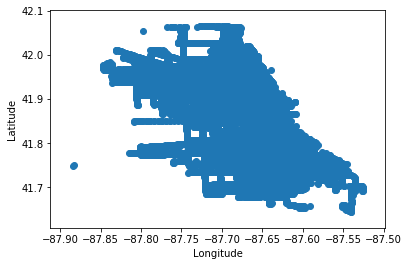

In [11]:
# Plotting the lat/long to find any bad positions
plt.scatter(bus_df['Longitude'], bus_df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [15]:
# Checking out the far western stops
bus_df[bus_df['Longitude'] < -87.85]

,Longitude,Latitude,Name,Status,Direction,Street
882,-87.884297,41.747604,Ups Facility Stop 1,In Service,NEB,UPS FACILITY
6652,-87.882337,41.750192,Ups Facility Stop 2,In Service,NEB,UPS FACILITY


There are a couple of far western bus stops.  Further investigation shows that they are valid UPS stops. 

In [16]:
# Saving all bus stops to csv
bus_df.to_csv('bus_stops.csv', index = False)

## Train Stops

In [12]:
# Reading in train stop file
train_df = pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops.csv')

In [13]:
train_df.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30213,N,35-Bronzeville-IIT (Harlem-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 17 columns):
STOP_ID                     300 non-null int64
DIRECTION_ID                300 non-null object
STOP_NAME                   300 non-null object
STATION_NAME                300 non-null object
STATION_DESCRIPTIVE_NAME    300 non-null object
MAP_ID                      300 non-null int64
ADA                         300 non-null bool
RED                         300 non-null bool
BLUE                        300 non-null bool
G                           300 non-null bool
BRN                         300 non-null bool
P                           300 non-null bool
Pexp                        300 non-null bool
Y                           300 non-null bool
Pnk                         300 non-null bool
O                           300 non-null bool
Location                    300 non-null object
dtypes: bool(10), int64(2), object(5)
memory usage: 19.4+ KB


In [15]:
# Creating a new column with just the train line associated with the stop
train_df['LINE'] = train_df['STATION_DESCRIPTIVE_NAME'].apply(lambda name: name.split('(')[1].split(')')[0])

In [16]:
train_df.tail(10)

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location,LINE
290,30061,S,Western (Midway-bound),Western,Western (Orange Line),40310,True,False,False,False,False,False,False,False,False,True,"(41.804546, -87.684019)",Orange Line
291,30060,N,Western (Loop-bound),Western,Western (Orange Line),40310,True,False,False,False,False,False,False,False,False,True,"(41.804546, -87.684019)",Orange Line
292,30130,S,Western (O'Hare Branch) (Forest Pk-bound),Western,Western (Blue Line - O'Hare Branch),40670,True,False,True,False,False,False,False,False,False,False,"(41.916157, -87.687364)",Blue Line - O'Hare Branch
293,30042,E,Western (Forest Pk Branch) (O'Hare-bound),Western,Western (Blue Line - Forest Park Branch),40220,False,False,True,False,False,False,False,False,False,False,"(41.875478, -87.688436)",Blue Line - Forest Park Branch
294,30043,W,Western (Forest Pk Branch) (Forest Pk-bound),Western,Western (Blue Line - Forest Park Branch),40220,False,False,True,False,False,False,False,False,False,False,"(41.875478, -87.688436)",Blue Line - Forest Park Branch
295,30106,S,Wilson (95th-bound),Wilson,Wilson (Red & Purple Lines),40540,True,True,False,False,False,False,False,False,False,False,"(41.964273, -87.657588)",Red & Purple Lines
296,30105,N,Wilson (Howard-bound),Wilson,Wilson (Red & Purple Lines),40540,True,True,False,False,False,False,False,False,False,False,"(41.964273, -87.657588)",Red & Purple Lines
297,30385,S,Wilson (Loop-bound),Wilson,Wilson (Red & Purple Lines),40540,True,False,False,False,False,False,True,False,False,False,"(41.964273, -87.657588)",Red & Purple Lines
298,30386,N,Wilson (Linden-bound),Wilson,Wilson (Red & Purple Lines),40540,True,False,False,False,False,False,True,False,False,False,"(41.964273, -87.657588)",Red & Purple Lines
299,30033,W,Ashland (Harlem-54th/Cermak-bound),Ashland,Ashland (Green & Pink Lines),40170,True,False,False,True,False,False,False,False,True,False,"(41.885269, -87.666969)",Green & Pink Lines


In [17]:
# Creating new columns for lat/long by splitting the location column
train_df['LATITUDE'] = train_df['Location'].apply(lambda loc: float(loc.split('(')[1].split(', ')[0]))
train_df['LONGITUDE'] = train_df['Location'].apply(lambda loc: float(loc.split('(')[1].split(', ')[1].split(')')[0]))

In [18]:
train_df.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location,LINE,LATITUDE,LONGITUDE
0,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)",Pink Line,41.857908,-87.669147
1,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)",Pink Line,41.857908,-87.669147
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)",Orange Line,41.829353,-87.680622
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)",Orange Line,41.829353,-87.680622
4,30213,N,35-Bronzeville-IIT (Harlem-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)",Green Line,41.831677,-87.625826


In [19]:
# Grabbing a few columns and renaming
train_df = train_df[['STOP_NAME', 'DIRECTION_ID', 'STATION_NAME', 'LINE', 'LATITUDE', 'LONGITUDE']]
train_df.columns = ['Stop_Name', 'Direction', 'Station', 'Line', 'Latitude', 'Longitude']

In [20]:
train_df.head()

,Stop_Name,Direction,Station,Line,Latitude,Longitude
0,18th (Loop-bound),E,18th,Pink Line,41.857908,-87.669147
1,18th (54th/Cermak-bound),W,18th,Pink Line,41.857908,-87.669147
2,35th/Archer (Loop-bound),N,35th/Archer,Orange Line,41.829353,-87.680622
3,35th/Archer (Midway-bound),S,35th/Archer,Orange Line,41.829353,-87.680622
4,35-Bronzeville-IIT (Harlem-bound),N,35th-Bronzeville-IIT,Green Line,41.831677,-87.625826


In [21]:
# Checking unique lines
set(train_df['Line'])

{'Blue Line',
 'Blue Line - Forest Park Branch',
 "Blue Line - O'Hare Branch",
 'Blue, Brown, Green, Orange, Purple & Pink Lines',
 'Brown & Purple Lines',
 'Brown Line',
 'Brown, Green, Orange, Pink & Purple Lines',
 'Brown, Green, Orange, Purple & Pink Lines',
 'Brown, Orange, Purple & Pink Lines',
 'Green & Pink Lines',
 'Green Line',
 'Orange Line',
 'Pink Line',
 'Purple Line',
 'Red & Purple Lines',
 'Red Line',
 'Red, Brown & Purple Lines',
 'Red, Orange & Green Lines',
 'Red, Purple & Yellow Lines',
 'Yellow Line'}

I will leave the line names as is for now. 

Text(0,0.5,'Latitude')

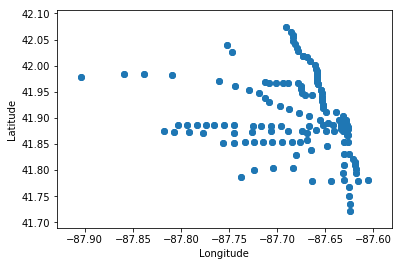

In [22]:
# Checking for any bad lat/long points
plt.scatter(train_df['Longitude'], train_df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [32]:
# Saving all train stops to csv
train_df.to_csv('train_stops.csv', index = False)

## Distance from Nearest Train Stop

In [33]:
# Reading in crime data
crime_df = pd.read_csv('Crimes_2001_into_2018_Cleaned.csv')

In [34]:
crime_df.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False


In [35]:
# Creating a temporary dataframe with non-null entries of latitude and longitude
crime_df_notnull = crime_df[pd.notnull(crime_df['Latitude'])]

# Resetting the index for crime_df_notnull before moving on
crime_df_notnull = crime_df_notnull.reset_index(drop = True)

In [36]:
# Converting the train stop coordinates to radians and zipping them together 
train = list(zip(np.deg2rad(train_df['Latitude']), np.deg2rad(train_df['Longitude'])))

# The BallTree is created using the train stop coordinates
tree = BallTree(train, metric = DistanceMetric.get_metric('haversine'))

# Converting the crime coordinates to radians and zipping them together
crime = list(zip(np.deg2rad(crime_df_notnull['Latitude']), np.deg2rad(crime_df_notnull['Longitude'])))

In [37]:
# Finding the closest train stop for each crime (splitting in half to reduce run time)
dists, ind = tree.query(crime[0:3333088], k=1) # returns distance and index of nearest train stop
dists2, ind2 = tree.query(crime[3333088:], k=1) 

In [38]:
# Combining dists and ind
dists_all = np.vstack([dists, dists2])
ind_all = np.vstack([ind, ind2])

# Extracting the nearest train stop name from ind_all
index_train = list(ind_all[:,0])
stops_train = list(train_df['Station'][index_train])
line_train = list(train_df['Line'][index_train])

# Extracting the distance from the nearest train stop from dists_all and converting from radians to km
distances_train = list((dists_all[:,0] * 6371).round(2))

In [39]:
# Creating new columns
crime_df_notnull['Closest Train Stop'] = stops_train
crime_df_notnull['Closest Train Line'] = line_train
crime_df_notnull['Distance from Closest Train Stop (km)'] = distances_train

In [40]:
len(ind_all) - len(crime_df_notnull)

0

In [41]:
crime_df_notnull.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74


## Distance from Nearest Bus Stop

In [44]:
bus_df.head()

,Longitude,Latitude,Name,Status,Direction,Street
0,-87.612263,41.692670,111th Street & Vernon,In Service,EB,111TH STREET
1,-87.548627,41.728184,92nd Street & Baltimore,In Service,EB,92ND STREET
2,-87.737227,41.749111,79th Street & Kilpatrick,In Service,EB,79TH STREET
3,-87.743974,41.924143,Fullerton & Kilpatrick,In Service,EB,FULLERTON
4,-87.659294,41.869314,Taylor & Throop,In Service,EB,TAYLOR


In [47]:
# Converting the bus stop coordinates to radians and zipping them together 
bus = list(zip(np.deg2rad(bus_df['Latitude']), np.deg2rad(bus_df['Longitude'])))

# The BallTree is created using the bus stop coordinates
tree = BallTree(bus, metric = DistanceMetric.get_metric('haversine'))

In [48]:
# Finding the closest bus stop for each crime - splitting in two to reduce run time
dists, ind = tree.query(crime[0:3333088], k=1) # returns distance and index of nearest bus stop
dists2, ind2 = tree.query(crime[3333088:], k=1) 

In [49]:
# Combining dists and ind
dists_all = np.vstack([dists, dists2])
ind_all = np.vstack([ind, ind2])

# Extracting the nearest bus stop name from ind_all
index_bus = list(ind_all[:,0])
stops_bus = list(bus_df['Name'][index_bus])

# Extracting the distance from the nearest bus stop from dists_all and converting from radians to km
distances_bus = list((dists_all[:,0] * 6371).round(2))

In [50]:
# Creating new columns
crime_df_notnull['Closest Bus Stop'] = stops_bus
crime_df_notnull['Distance from Closest Bus Stop (km)'] = distances_bus

In [51]:
crime_df_notnull.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13


In [52]:
crime_df_notnull.columns

Index(['ID', 'Date', 'Year', 'Block', 'Primary Type', 'Location Description',
       'Domestic', 'Beat', 'District', 'Ward', 'Community', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude', 'Month', 'Season',
       'Quarter of Year', 'Day of the Week', 'Day Type', 'Time of Day', 'Day',
       'Hour', 'Third of Month', 'Street', 'Holiday', 'Is Holiday',
       'Closest Train Stop', 'Closest Train Line',
       'Distance from Closest Train Stop (km)', 'Closest Bus Stop',
       'Distance from Closest Bus Stop (km)'],
      dtype='object')

In [53]:
# Joining crime_df_notnull with crime_df
crime_df2 = pd.merge(crime_df, crime_df_notnull[['ID', 'Closest Train Stop', 'Closest Train Line', 'Distance from Closest Train Stop (km)', 
                                                 'Closest Bus Stop', 'Distance from Closest Bus Stop (km)' ]], left_on = 'ID', right_on = 'ID', how = 'left')

In [54]:
crime_df2.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13


In [57]:
# Saving crime_df2 to csv
crime_df2.to_csv('Crimes_2001_into_2018_Cleaned.csv', index = False)